# Plots of the yield models used in R68 analysis

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

exec(open("nb_setup.py").read())
import R68_yield as Yield

../mplstyles
3.0.3
/data/chocula/mast/cdms/analysis/run068/R68_paper2019/mplstyles


In [9]:
E_thresh=50 #[eV] Possible analysis threshold
E_test=np.logspace(-1,3,1000)

fig_w=7

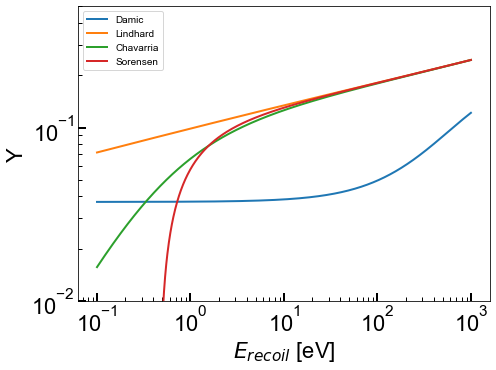

In [10]:
fig,ax = plt.subplots(1,1,figsize=(fig_w, fig_w*(.75)))

Y=Yield.Yield('Damic',[])
plt.plot(E_test,Y.calc(E_test),label='Damic')

Y=Yield.Yield('Lind',[0.179])
plt.plot(E_test,Y.calc(E_test),label='Lindhard')

Y=Yield.Yield('Chav',[0.179,0.2])
plt.plot(E_test,Y.calc(E_test),label='Chavarria')

Y=Yield.Yield('Sor',[0.179,1e-6])
plt.plot(E_test,Y.calc(E_test),label='Sorensen')


plt.gca().set_xlabel(r'$E_{recoil}$ [eV]')
plt.gca().set_ylabel('Y')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_ylim(1e-2,0.5)

plt.legend()
plt.tight_layout()
#plt.savefig('figures/R68_Y_fit/Ytest1.png')